In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
#%config InlineBackend.figure_format = 'svg'

In [2]:
def dj_oracle(case, n):

    oracle_qc = QuantumCircuit(n+1)

    if case == "balanced":
        
        b = np.random.randint(1,2**n)

        b_str = format(b, '0'+str(n)+'b')
 
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
     
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
    
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        
    if case == "constant":
        
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    return oracle_qc

In [3]:
def dj_algorithm(oracle,n,dj_circuit):
    #dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)

    dj_circuit.barrier()
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(0,n):
        dj_circuit.measure(i,i)
    
    return dj_circuit

In [4]:
def getKeysByValue(dictOfElements):
    valueToFind = max(dictOfElements.values())
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys[0]

In [5]:
def deusch_jozsa_algorithm(quantum_circuit, oracle_type, nQubits):
    oracle_gate = dj_oracle(oracle_type, nQubits)
    dj_circuit = dj_algorithm(oracle_gate.to_gate(), nQubits, quantum_circuit)
    #dj_circuit.draw(output = "mpl")
    return dj_circuit

In [6]:

def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

In [7]:
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

In [8]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

In [9]:
def create_superdense_coding(msg):
    qr = QuantumRegister(len(message)+1)
    cr = ClassicalRegister(len(message))
    quantum_circuit = QuantumCircuit(qr,cr)
    # First, Charlie creates the entangled pair between Alice and Bob
    for qbit in range(0,len(msg)-1,2):
        create_bell_pair(quantum_circuit, qbit, qbit+1)

        quantum_circuit.barrier(qbit, qbit+1)

        encode_message(quantum_circuit, qbit, msg[qbit:qbit+2])

    quantum_circuit.barrier()
    i=0
    for qbit in range(0,len(message)-1,2):
        decode_message(quantum_circuit, qbit, qbit+1)
        

    return quantum_circuit    

## Simulación y ejecución en máquina real para un Oráculo Balanceado

In [10]:
message = "1011"
nQubits=len(message)
qc = create_superdense_coding(message)
#qc.draw(output = "mpl")

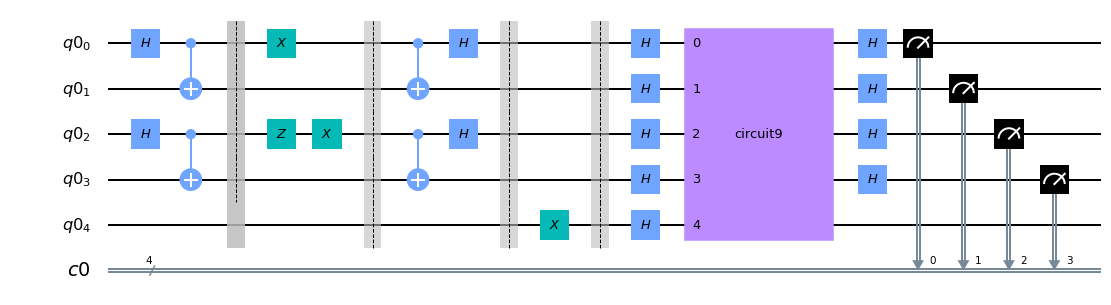

In [11]:
qc.barrier()
qc = deusch_jozsa_algorithm(qc,'balanced', nQubits)
qc.draw('mpl')

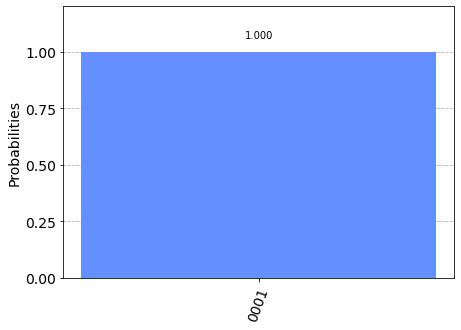

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [26]:
message = "1011"    
nQubits=len(message)
qc = create_superdense_coding(message)
#qc.draw(output = "mpl")

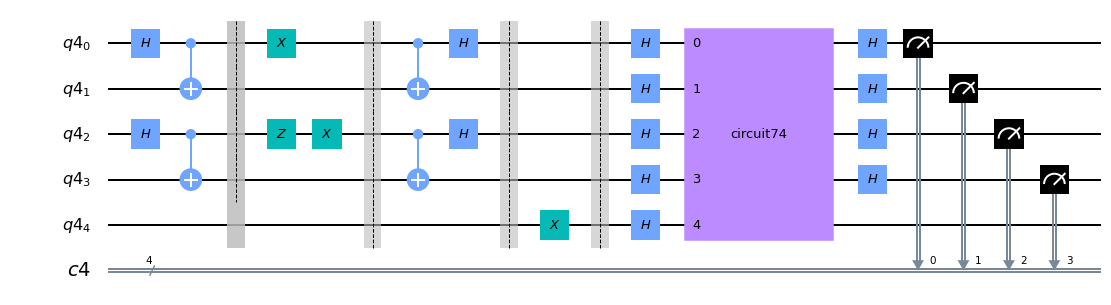

In [27]:
qc.barrier()
qc = deusch_jozsa_algorithm(qc,'balanced', nQubits)
qc.draw('mpl')

In [31]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 256

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
job = execute(qc, backend=backend, shots=shots)

ibmqfactory.load_account:WARNING:2020-06-19 19:34:24,131: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_essex


In [32]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


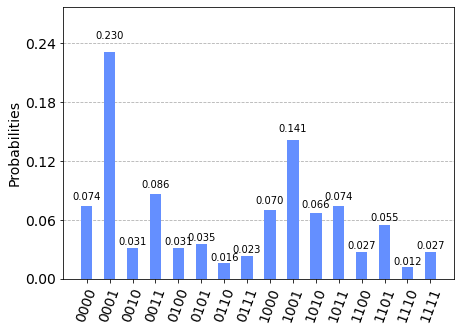

In [33]:
result = job.result()
measurement_result = result.get_counts(qc)
plot_histogram(measurement_result)

## Simulación y ejecución en máquina real para un Oráculo Constante

In [18]:
message = "1011"
nQubits=len(message)
qc = create_superdense_coding(message)
#qc.draw(output = "mpl")

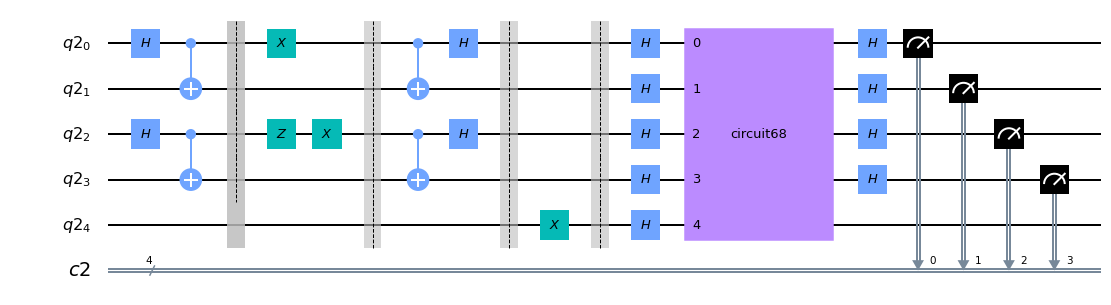

In [19]:
qc.barrier()
qc = deusch_jozsa_algorithm(qc,'constant', nQubits)
qc.draw('mpl')

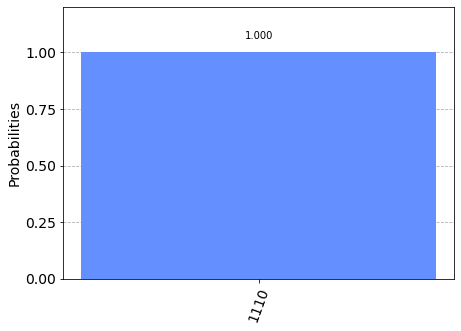

In [20]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [21]:
message = "1011"    
nQubits=len(message)
qc = create_superdense_coding(message)
#qc.draw(output = "mpl")

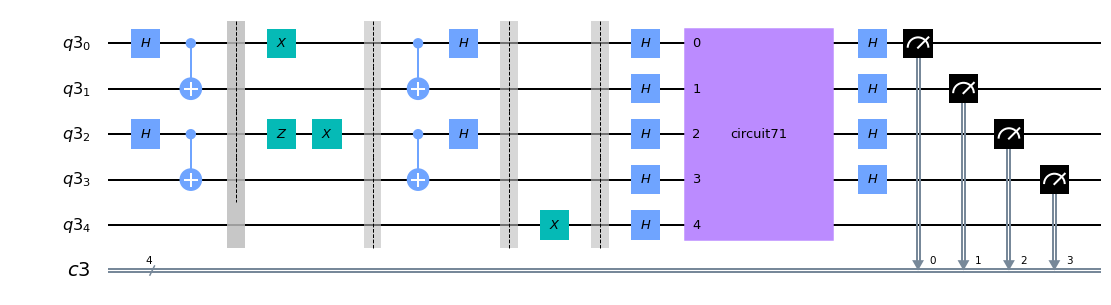

In [22]:
qc.barrier()
qc = deusch_jozsa_algorithm(qc,'constant', nQubits)
qc.draw('mpl')

In [23]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 256

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
job = execute(qc, backend=backend, shots=shots)

ibmqfactory.load_account:WARNING:2020-06-19 19:32:42,411: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_essex


In [24]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


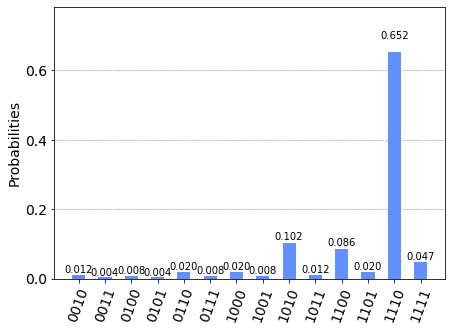

In [25]:
result = job.result()
measurement_result = result.get_counts(qc)
plot_histogram(measurement_result)